# Polynomial regression  

> `Features --> Polynomial transformation --> Linear regression --> Label`  


### Import libraries  

In [ ]:
from IPython.display import display, Math, Latex

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

### Get linear regression class from previous week  

In [ ]:
# Linear regression class  
class LinReg(object):
  
  def __init__(self):
    self.t0 = 200
    self.t1 = 100000

  def predict(self, X:np.ndarray) -> np.ndarray:
    y = X @ self.w
    return y

  def loss(self, X:np.ndarray, y:np.ndarray) -> float:
    e = y - self.predict(X)
    return (1/2) * (np.transpose(e) @ e)

  def rmse(self, X:np.ndarray, y:np.ndarray) -> float:
    return np.sqrt((2/X.shape[0]) * self.loss(X, y))

  def fit(self, X:np.ndarray, y:np.ndarray) -> np.ndarray:
    self.w = np.linalg.pinv(X) @ y
    return self.w

  def calculate_gradient(self, X:np.ndarray, y:np.ndarray) -> np.ndarray:
    return np.transpose(X) @ (self.predict(X) - y)

  def update_weights(self, grad:np.ndarray, lr:float) -> np.ndarray:
    return (self.w - lr*grad)

  def learning_schedule(self, t):
    return self.t0 / (t + self.t1)

  def gd(self, X:np.ndarray, y:np.ndarray, num_epochs:int, lr:float) -> np.ndarray:
    self.w = np.zeros((X.shape[1]))
    self.w_all = []
    for i in np.arange(0, num_epochs):
      dJdw = self.calculate_gradient(X, y)
      self.w_all.append(self.w)
      self.err_all.append(self.loss(X, y))
      self.w = self.update_weights(dJdw, lr)
    return self.w

  def mbgd(self, X:np.ndarray, y:np.ndarray, num_epochs:int, batch_size: int) -> np.ndarray:
    '''mini-batch gradient descent'''
    self.w = np.zeros((X.shape[1]))
    self.w_all = []
    self.err_all = []
    mini_batch_id = 0

    for epoch in range(num_epochs):
      shuffled_indices = np.random.permutation(X.shape[0])
      X_shuffled = X[shuffled_indices]
      y_shuffled = y[shuffled_indices]
      for i in range(0, X.shape[0], batch_size):
        mini_batch_id += 1
        xi = X_shuffled[i:i+batch_size]
        yi = y_shuffled[i:i+batch_size]

        self.w_all.append(self.w)
        self.err_all.append(self.loss(xi, yi))

        dJdw = 2/batch_size * self.calculate_gradient(xi, yi)
        self.w = self.update_weights(dJdw, self.learning_schedule(mini_batch_id))

    return self.w

  def sgd(self, X:np.ndarray, y:np.ndarray, num_epochs:int) -> np.ndarray:
    '''stochastic gradient descent'''

    # Parameter vector initialized to [0, 0]
    self.w = np.zeros((X.shape[1]))
    self.w_all = []
    self.err_all = []
    for epoch in range(num_epochs):
      for i in range(X.shape[0]):
        random_index = np.random.randint(X.shape[0])
        xi = X[random_index:random_index+1]
        yi = y[random_index:random_index+1]

        self.w_all.append(self.w)
        self.err_all.append(self.loss(xi, yi))

        gradients = 2 * self.calculate_gradient(xi, yi)
        lr = self.learning_schedule(epoch * X.shape[0] + i)
        self.w = self.update_weights(gradients, lr)

    return self.w
  
    

## Polynomial transformation  

Steps for generating polynomial transformation of degree M  

1. Generate combination of input features of lengths = 0, 1, 2,...,M.  
2. Perform multiplication operation between features to obtain the new features.  

In [ ]:
import itertools
import functools

def get_combinations(x, degree):
  return itertools.combinations_with_replacement(x, degree)

def compute_new_feature(items):
  '''reduce(lambda x,y: x*y, [1,2,3,4,5]) calculates ((((1*2)*3)*4)*5)'''
  return functools.reduce(lambda x, y: x * y, items)

Let's run `get_combinations` on a few examples:

In [ ]:
{items: compute_new_feature(items) for items in get_combinations([1], 3)}

{(1, 1, 1): 1}

In [ ]:
{items: compute_new_feature(items) for items in get_combinations([2, 3], 3)}

{(2, 2, 2): 8, (2, 2, 3): 12, (2, 3, 3): 18, (3, 3, 3): 27}

In [ ]:
{items: compute_new_feature(items) for items in get_combinations([1, 4], 4)}


{(1, 1, 1, 1): 1,
 (1, 1, 1, 4): 4,
 (1, 1, 4, 4): 16,
 (1, 4, 4, 4): 64,
 (4, 4, 4, 4): 256}

## Polynomial transform function  

In [ ]:
# Implementation adopted from (https://github.com/ctgk/PRML/blob/master/prml/preprocess/polynomial.py)

import numpy as np
import itertools
import functools

def polynomial_transform(x, degree, logging=False):
  # converts to feature matrix
  if x.ndim == 1:
    x = x[:, None]

  x_t = x.transpose()   # Transpose of feature matrix
  features = [np.ones(len(x))]    # Populates 1s as first feature for each example

  if logging:
    print(f"Input: {x}")

  for degree in range(1, degree+1):
    for items in get_combinations(x_t, degree):   # generate combinations.
      features.append(compute_new_feature(items)) # combine features into a new feature.
      if logging:
        print(f"{items}: {compute_new_feature(items)}")
  
  
  polynomial_feature_matrix = np.asarray(features).transpose()

  if logging:
    print(polynomial_feature_matrix)
  return polynomial_feature_matrix

In [ ]:
polynomial_transform(np.array([2]), 3, logging=True)    # One feature, one example/sample/row, desired_degree = 3

Input: [[2]]
(array([2]),): [2]
(array([2]), array([2])): [4]
(array([2]), array([2]), array([2])): [8]
[[1. 2. 4. 8.]]


array([[1., 2., 4., 8.]])

In [ ]:
polynomial_transform(np.array([2, 3]), 2, logging=True)   # One feature, two examples, desired_degree = 2


Input: [[2]
 [3]]
(array([2, 3]),): [2 3]
(array([2, 3]), array([2, 3])): [4 9]
[[1. 2. 4.]
 [1. 3. 9.]]


array([[1., 2., 4.],
       [1., 3., 9.]])

In [ ]:
polynomial_transform(np.array([[2, 3], [4, 5]]), 2, logging=True)   # Two features, two examples, desired_degree = 2


Input: [[2 3]
 [4 5]]
(array([2, 4]),): [2 4]
(array([3, 5]),): [3 5]
(array([2, 4]), array([2, 4])): [ 4 16]
(array([2, 4]), array([3, 5])): [ 6 20]
(array([3, 5]), array([3, 5])): [ 9 25]
[[ 1.  2.  3.  4.  6.  9.]
 [ 1.  4.  5. 16. 20. 25.]]


array([[ 1.,  2.,  3.,  4.,  6.,  9.],
       [ 1.,  4.,  5., 16., 20., 25.]])

In [ ]:
# Visualize the input feature matrix used above and below
print(np.array([[2, 3], [4, 5]]))

[[2 3]
 [4 5]]


In [ ]:
polynomial_transform(np.array([[2, 3], [4, 5]]), 3, logging=True)   # Two features, two examples, desired_degree = 3


Input: [[2 3]
 [4 5]]
(array([2, 4]),): [2 4]
(array([3, 5]),): [3 5]
(array([2, 4]), array([2, 4])): [ 4 16]
(array([2, 4]), array([3, 5])): [ 6 20]
(array([3, 5]), array([3, 5])): [ 9 25]
(array([2, 4]), array([2, 4]), array([2, 4])): [ 8 64]
(array([2, 4]), array([2, 4]), array([3, 5])): [12 80]
(array([2, 4]), array([3, 5]), array([3, 5])): [ 18 100]
(array([3, 5]), array([3, 5]), array([3, 5])): [ 27 125]
[[  1.   2.   3.   4.   6.   9.   8.  12.  18.  27.]
 [  1.   4.   5.  16.  20.  25.  64.  80. 100. 125.]]


array([[  1.,   2.,   3.,   4.,   6.,   9.,   8.,  12.,  18.,  27.],
       [  1.,   4.,   5.,  16.,  20.,  25.,  64.,  80., 100., 125.]])

In [ ]:
polynomial_transform(np.array([2]), 0, logging=True)   # One feature, one example, desired_degree = 0


Input: [[2]]
[[1.]]


array([[1.]])

## Generate non-linear training data  


We generate training data with a single feature x1 and label y = sin(2\*pi\*x) + noise

In [ ]:
# Create a training set where the output label is obtained by first 
# calculating sin(2*pi*x) and then adding a small random noise having
# a gaussian distribution

def create_nonlin_training_set(func, sample_size, std):
  x = np.linspace(0, 1, sample_size)
  y = func(x) + np.random.normal(scale=std, size=x.shape)
  return x, y

def nonlin(x):
  return np.sin(2 * np.pi * x)

# Visualization of training data and model fitment.

In [1]:
# write code for data visualization

def visualize_training_data(X_train, y_train):
  points = np.linspace(0, 1, 100)
  output = nonlin(points)

  plt.scatter(X_train, y_train, facecolor="none", edgecolor="b", s=50, label="training data")
  plt.plot(points, output, c="g", label="$\sin(2\pi x)$")
  plt.xlabel("$x_1$")
  plt.ylabel("y")
  plt.legend()
  plt.show()

def visualize_model_fit(X, y, lin_reg, degree):
  '''Plots trained model along with the data generation fuction output'''
  points = np.linspace(0, 1, 100)
  output = nonlin(points)

  if degree > 0:
    plt.scatter(X, y, facecolor="none", edgecolor="b", s=50, label="training data")
  plt.plot(points, output, c="g", label="$\sin(2\pi x)$")

  y_hat = lin_reg.predict(polynomial_transform(points, degree))
  plt.plot(points, y_hat, c="r", label="$h_\mathbf{w}(x)$")
  plt.xlabel("$x_1$")
  plt.ylabel("y")
  plt.ylim(-1.5, 1.5)
  plt.title("M={}".format(degree))    # xy = (-0.15, 1)

We can set the number of samples required and control noise added to examples through `std` parameter.

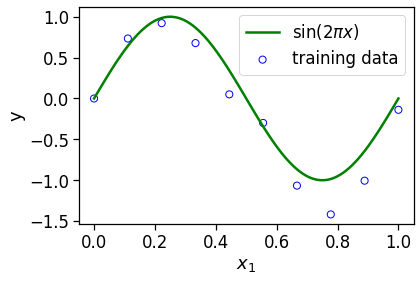

In [ ]:
num_samples = 10
X, y = create_nonlin_training_set(nonlin, num_samples, 0.2)   # Manipulate noise (std parameter) to see what happens to data
visualize_training_data(X, y)

## Polynomial model  

Let's train a polynomial model on this data

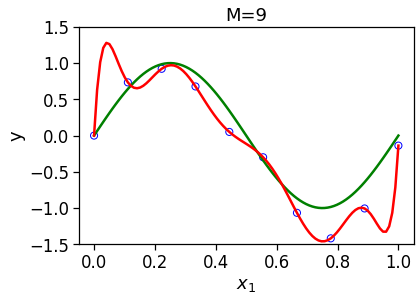

In [ ]:
# [Activity]: Change the degree here and examine the fitment. (esp try degree 2 or 3)
degree = 9
X_transform = polynomial_transform(X, degree)
lin_reg = LinReg()
lin_reg.fit(X_transform, y)
visualize_model_fit(X, y, lin_reg, degree)

Let's train multiple polynomial regression models with different degrees.

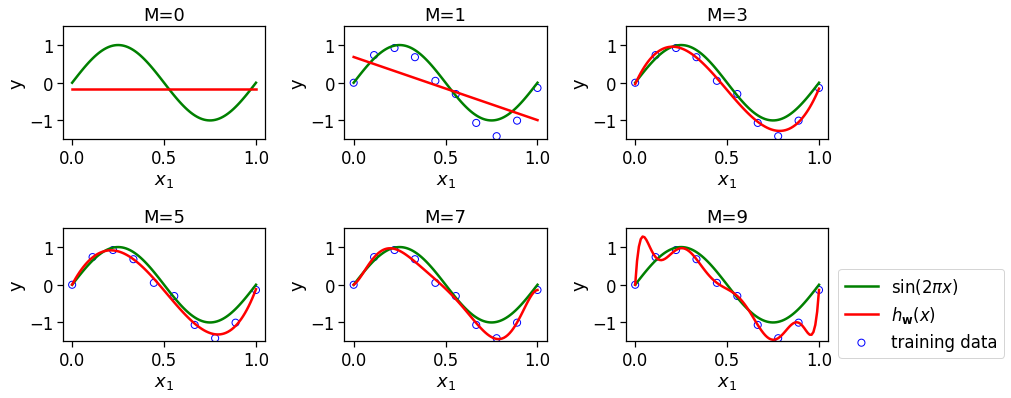

In [ ]:
f = plt.figure(figsize=(12, 8))
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

for i, degree in enumerate([0, 1, 3, 5, 7, 9]):
  plt.subplot(3, 3, i+1)
  X_transform = polynomial_transform(X, degree)
  lin_reg = LinReg()
  lin_reg.fit(X_transform, y)
  visualize_model_fit(X, y, lin_reg, degree)

f.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 0.64), loc=2, borderaxespad=0.)
plt.show()

## Model selection

* One polynomial per degree. Which one to select?  
* Process  
  * Fix the list of degrees that you want to experiment with.  
  * Divide the training data into training, validation and test.  
  * For each degree m:
    * Training polynomial regression model with training data.  
    * Calculate training and validation errors on the trained model.  
* Select the model with the lowest training and validation loss among all models.  

In [ ]:
#@title [Model selection helpers]
import pandas as pd

def convert_dict_to_df(w_dict, degree):
  poly_w_dict = {i:np.array(np.zeros(degree)) for i in range(degree)}
  for deg in poly_w_dict:
    weight_vec = w_dict[deg]
    for i in range(len(weight_vec)):
      poly_w_dict[deg][i] = weight_vec[i]

  poly_w_df = pd.DataFrame(poly_w_dict)
  poly_w_df.columns = ['w_'+str(i) for i in range(degree)]
  return poly_w_df

def plot_model_selection(training_errors, val_errors):
  plt.plot(training_errors, 'o-', mfc="none", mec="b", ms=10, c="b", label="Training")
  plt.plot(val_errors, 'o-', mfc="none", mec="r", ms=10, c="r", label="Validation")
  plt.legend()
  plt.xlabel("degree")
  plt.ylabel("RMSE")
  plt.show()

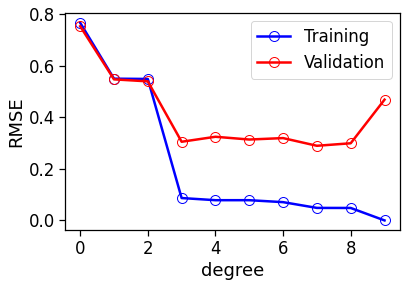

,w_0,w_1,w_2,w_3,w_4,w_5,w_6,w_7,w_8,w_9
0,-0.154305,0.682921,0.741149,-0.035624,0.003913,0.004618,-0.007799,0.000804,0.000530,-0.000163
1,0.000000,-1.674451,-2.067495,10.721532,9.238892,9.174675,12.488096,3.184143,5.144561,77.472005
2,0.000000,0.000000,0.393043,-33.313393,-25.826064,-25.290769,-66.169340,87.353176,47.818538,-1622.819419
3,0.000000,0.000000,0.000000,22.470957,10.461578,8.948479,184.893680,-725.512376,-427.319222,14620.731211
4,0.000000,0.000000,0.000000,0.000000,6.004690,7.739044,-332.270814,2241.957864,1117.040665,-69576.694135
5,0.000000,0.000000,0.000000,0.000000,0.000000,-0.693742,301.750967,-3452.224724,-1110.255232,191485.736715
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-100.814903,2623.469317,-108.828424,-315473.102006
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-778.366920,894.468432,306778.225962
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-418.208838,-162252.968361
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,35963.279894


In [ ]:
training_errors = []
val_errors = []
w_dict = {}

X_val = np.linspace(0, 1, 100)
y_val = nonlin(X_val)

for i in range(10):
  X_transform = polynomial_transform(X, i)
  X_val_transform = polynomial_transform(X_val, i)
  lin_reg = LinReg()
  lin_reg.fit(X_transform, y)

  w_dict[i] = lin_reg.w
  training_errors.append(lin_reg.rmse(X_transform, y))
  val_errors.append(lin_reg.rmse(X_val_transform, y_val + np.random.normal(scale=0.25, size=len(y_val))))

plot_model_selection(training_errors, val_errors)
convert_dict_to_df(w_dict, 10)

Observations:  
* Higher order polynomial terms are assigned larger weights. The larger weights are problematic as a small change in input causes a large change in output.  

This is called 'high variance' or overfitting problem.  
* We can fix the overfitting problem with more data. Try running the analysis with number of samples = 100, 1000, 10000 and observe the weight vectors for higher order polynomial models.  

* Note down which polynomial model is suitable for different sample sizes.  

* Note: We can also minimize overfitting problem using regularization.  

## 